# Unsupervised Learning, PCA, and Portfolio Management

PCA - principal component analysis (one of method for dimensionality reduction -> which is part of *unsupervised learning*)



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import warnings

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD #singular value decomposition

from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE # t-distributed stochastic embeddings

from sklearn.decomposition import KernelPCA

# if u wan PCA,  
#   1. imputation
#   2. normalisation,

from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix
import seaborn as sns

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
dow = pd.read_csv("dow_pca.csv", index_col = 0)
dow

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-25,195.900000,100.770000,157.760000,364.200000,136.860000,113.220000,46.130000,47.370000,111.090000,57.76,...,80.610000,40.298248,93.600000,124.980000,115.810000,268.050000,56.400000,138.67,96.940000,71.890000
2019-01-28,193.200000,100.380000,156.300000,362.970000,124.370000,112.170000,45.750000,47.170000,110.810000,58.13,...,80.320000,39.197582,93.520000,125.030000,115.080000,266.770000,55.070000,135.99,97.060000,71.580000
2019-01-29,196.950000,100.960000,154.680000,364.910000,126.530000,111.830000,45.960000,47.400000,110.900000,58.52,...,80.220000,40.427155,93.540000,124.820000,117.840000,267.340000,53.280000,135.00,96.710000,71.500000


<AxesSubplot:title={'center':'Correlation Matrix'}>

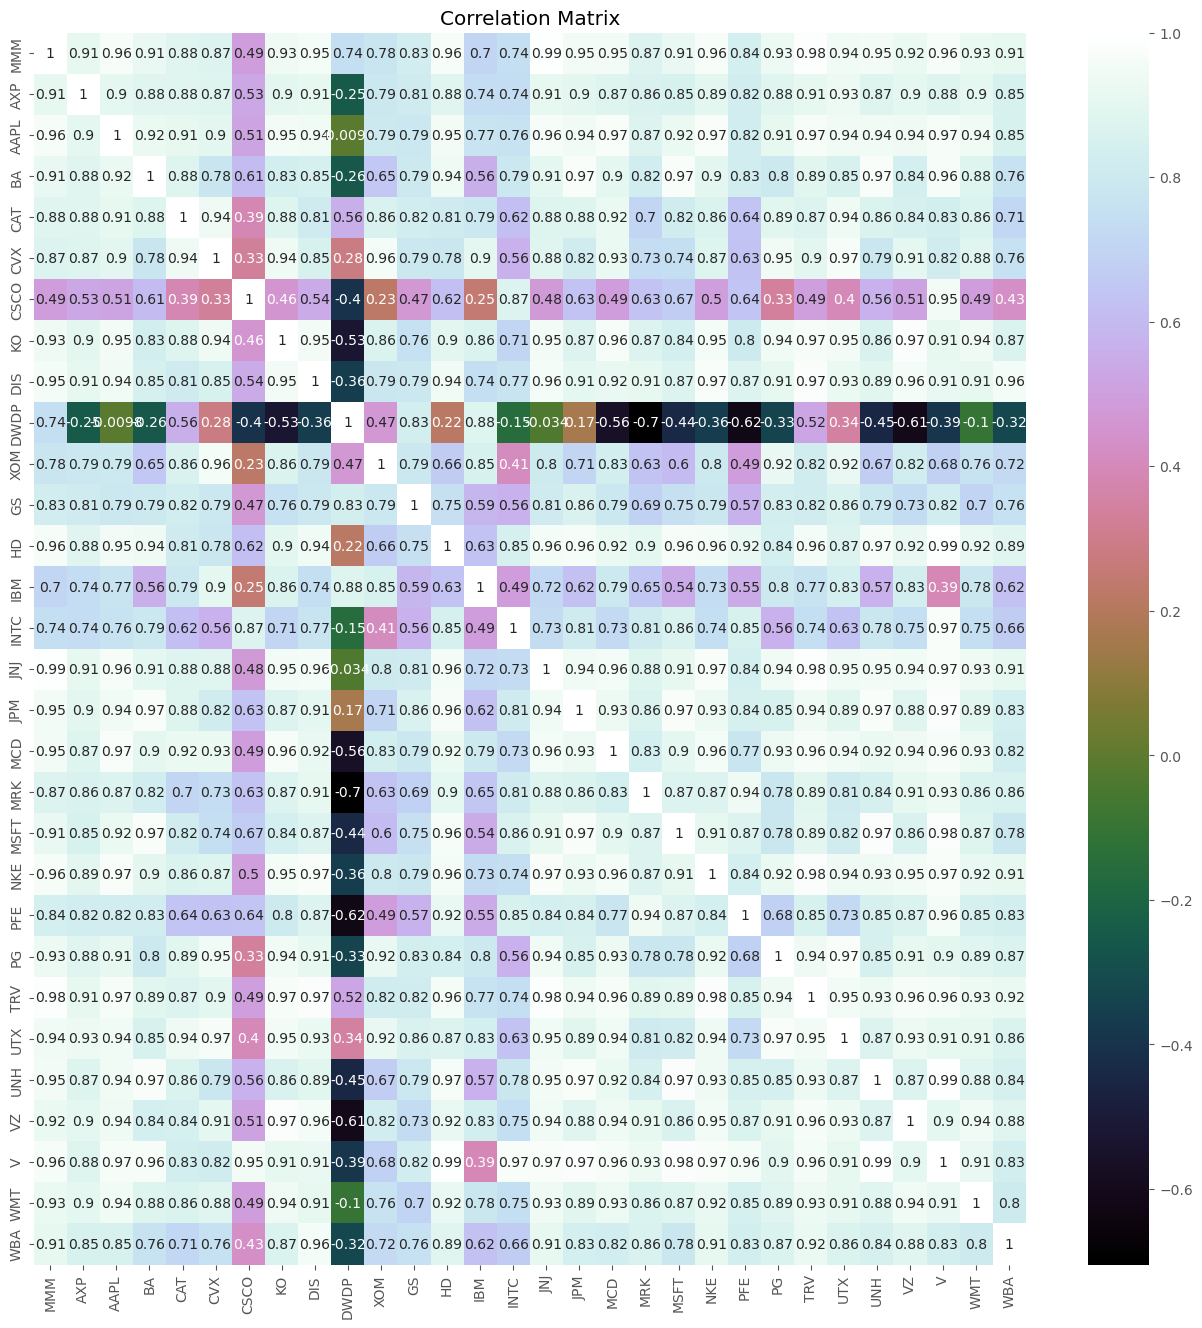

In [3]:
corr = dow.corr()

plt.figure(figsize = (16,16))
plt.title("Correlation Matrix")
sns.heatmap(corr, #heatmap gives u some idea if using unsupervised learning
            annot = True,
            cmap = "cubehelix")

### Data Transformation

In [4]:
missing_frac = dow.isnull().mean().sort_values(ascending = False)
missing_frac.head(7) #get rid of dwdp and v

DWDP    0.925208
V       0.429792
MMM     0.000000
JPM     0.000000
WMT     0.000000
VZ      0.000000
UNH     0.000000
dtype: float64

In [5]:
drop_list = sorted(list(missing_frac[missing_frac > 0.3].index))
dow.drop(labels = drop_list,
         axis = 1,
         inplace = True)

dow = dow.fillna(method = "ffill")
dow = dow.dropna(axis = 0)

In [6]:
Daily_Linear_Returns = dow.pct_change(1)
Daily_Linear_Returns = Daily_Linear_Returns[Daily_Linear_Returns.apply(lambda x:(x - x.mean()).abs() < (3 * x.std())).all(1)]
Daily_Linear_Returns

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.017595,0.009056,-0.051151,-0.015793,-0.015710,-0.009331,-0.030055,0.034008,0.010312,0.011940,...,-0.025657,0.050113,-0.001742,0.016393,-0.011299,-0.023209,0.002158,-0.009402,-0.014870,0.039649
2000-01-20,-0.037243,0.016790,0.065128,-0.023725,-0.044210,-0.005003,0.000890,0.009655,-0.032230,-0.021856,...,-0.009346,-0.023670,-0.016486,-0.024263,-0.005486,-0.022739,0.025210,0.003123,-0.010615,0.000000
2000-02-02,-0.017316,-0.028402,-0.014364,0.020114,0.005788,-0.006732,-0.033107,-0.030105,0.034722,0.007453,...,-0.020692,0.016063,-0.027027,-0.008744,-0.048789,0.001118,0.026451,-0.004197,-0.005282,0.004512
2000-02-03,-0.008757,-0.007917,0.045542,-0.026664,-0.026013,-0.014402,0.034241,-0.020043,0.016913,-0.017062,...,0.027874,0.009275,-0.010278,-0.008314,-0.044835,-0.015070,-0.008948,-0.014669,0.000000,-0.002073
2000-02-04,-0.028684,-0.009208,0.045397,0.012891,0.000000,-0.035363,0.028014,0.018100,0.006600,-0.018208,...,0.028373,-0.024854,0.003368,-0.031285,0.004506,-0.029467,0.024738,0.002053,-0.035457,0.010734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-22,-0.018380,-0.006469,-0.022446,-0.018726,-0.031918,-0.017749,-0.005552,0.002310,-0.003963,-0.015071,...,-0.018847,0.003729,-0.006113,-0.010720,-0.013305,-0.024934,0.000716,-0.001752,-0.002456,-0.011597
2019-01-24,0.001196,0.000100,-0.007926,-0.000948,0.006903,0.019032,0.003300,-0.012016,-0.005130,0.001403,...,-0.004779,-0.000745,-0.028700,-0.005694,0.011055,-0.012645,-0.003333,-0.011946,-0.003546,-0.005439
2019-01-25,0.017557,0.010529,0.033137,0.016552,0.031116,-0.002555,0.011401,-0.006710,0.004885,0.004482,...,0.009134,0.002113,-0.007570,-0.007423,0.004824,0.002163,0.007215,-0.011740,-0.014437,0.007992


In [7]:
scaler = StandardScaler().fit(Daily_Linear_Returns)
scaled_dow = pd.DataFrame(scaler.fit_transform(Daily_Linear_Returns),
                          columns = Daily_Linear_Returns.columns,
                          index = Daily_Linear_Returns.index)
Daily_Linear_Returns.dropna(how = "any", inplace = True)
scaled_dow.dropna(how = "any", inplace = True)
scaled_dow

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.712521,0.565691,-2.706654,-1.132481,-1.041358,-0.786700,-1.833460,3.568898,0.725032,0.982592,...,-1.936887,3.665184,-0.172566,1.771789,-0.935712,-1.953059,0.075872,-0.836586,-1.374890,2.940566
2000-01-20,-3.562560,1.077204,3.303984,-1.669782,-2.833229,-0.445275,0.021953,0.987494,-2.414233,-1.898706,...,-0.733282,-1.815495,-1.420623,-2.740544,-0.475548,-1.914564,1.653062,0.240404,-0.987215,-0.035980
2000-02-02,-1.686266,-1.911665,-0.805081,1.299992,0.310281,-0.581622,-2.016471,-3.227117,2.526288,0.600013,...,-1.570494,1.135937,-2.312844,-1.018077,-3.903262,0.037147,1.737972,-0.389089,-0.501300,0.302769
2000-02-03,-0.880286,-0.556838,2.291567,-1.868888,-1.689132,-1.186758,2.021564,-2.160496,1.212101,-1.490028,...,2.013181,0.631676,-0.895077,-0.970374,-3.590290,-1.287168,-0.683934,-1.289476,-0.020037,-0.191624
2000-02-04,-2.756592,-0.642216,2.284092,0.810688,-0.053647,-2.840583,1.648205,1.882606,0.451092,-1.587721,...,2.049979,-1.903447,0.259988,-3.519854,0.315415,-2.465062,1.620775,0.148399,-3.250692,0.769850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-22,-1.786452,-0.461057,-1.222855,-1.331178,-2.060399,-1.450893,-0.364317,0.208945,-0.328318,-1.320214,...,-1.434369,0.219723,-0.542571,-1.237389,-1.094497,-2.094194,-0.022789,-0.178781,-0.243790,-0.906623
2019-01-24,0.056873,-0.026588,-0.472295,-0.126838,0.380382,1.451057,0.166400,-1.309645,-0.414437,0.084196,...,-0.396322,-0.112639,-2.454472,-0.679580,0.833808,-1.088814,-0.299792,-1.055360,-0.343103,-0.444266
2019-01-25,1.597373,0.663167,1.650326,1.058656,1.902669,-0.252091,0.652146,-0.747231,0.324530,0.346719,...,0.630319,0.099711,-0.665890,-0.871510,0.340566,0.122711,0.421849,-1.037645,-1.335426,0.564008


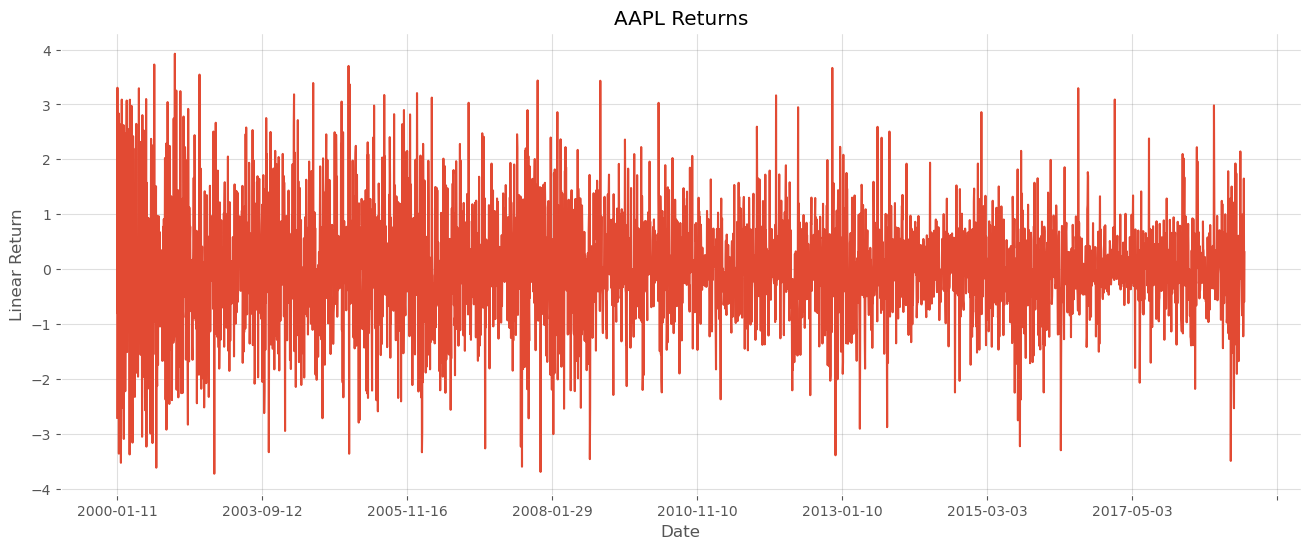

In [8]:
plt.figure(figsize = (16, 6)
           )

plt.title("AAPL Returns")

plt.ylabel("Linear Return")

scaled_dow.AAPL.plot()

plt.show()

### MODEL

In [9]:
prop = int(len(scaled_dow) * 0.80)

X_Train = scaled_dow[:prop]
X_Test = scaled_dow[prop:]

X_Train_Raw = Daily_Linear_Returns[:prop]
X_Test_Raw = Daily_Linear_Returns[prop:]

stock_tickers = scaled_dow.columns.values
n_tickers = len(stock_tickers)

pca = PCA()
PrincipalComponent = pca.fit(X_Train)
PrincipalComponent

PCA()

#### First Principal Component /Eigenvector

In [10]:
pca.components_[0] 

array([-0.228, -0.228, -0.153, -0.19 , -0.202, -0.178, -0.195, -0.168,
       -0.208, -0.193, -0.209, -0.202, -0.199, -0.195, -0.167, -0.228,
       -0.152, -0.17 , -0.194, -0.171, -0.19 , -0.168, -0.198, -0.227,
       -0.138, -0.167, -0.169, -0.161])

### Explained Variance

In [11]:
NumEigenvalues = 10 #greater than 1, meaningful

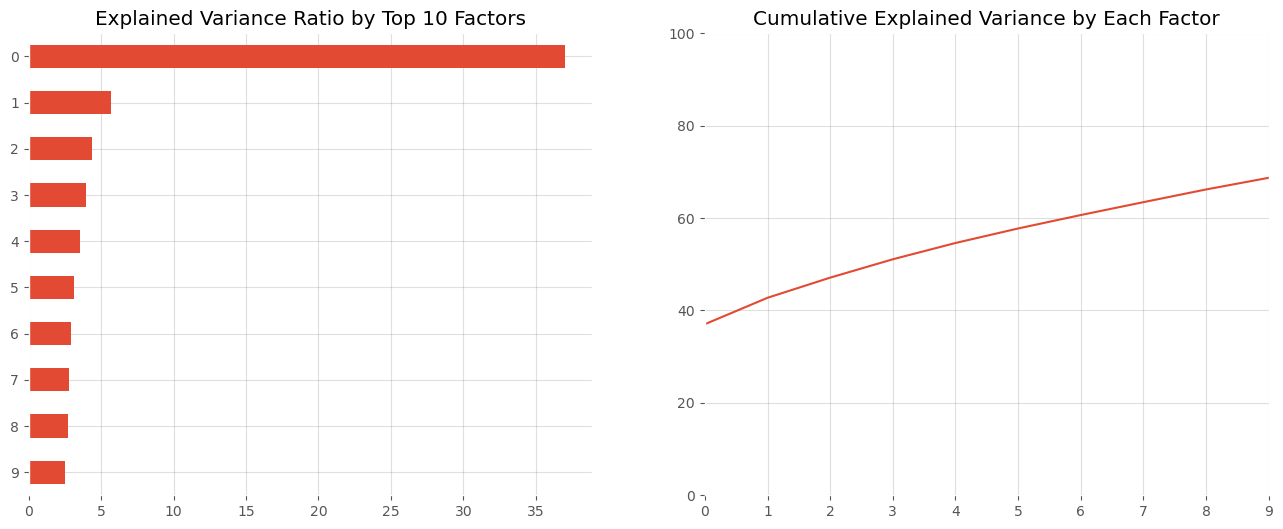

In [12]:
fig, axes = plt.subplots(ncols = 2,
                         figsize = (16, 6)
                         )

Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]
                   ).sort_values() * 100

Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]
                   ).cumsum()*100

Series1.plot.barh(ylim = (0, 9),
                  title = "Explained Variance Ratio by Top 10 Factors",
                  ax = axes[0]
                  );

Series2.plot(ylim = (0, 100),
             xlim = (0, 9),
             ax = axes[1],
             title = "Cumulative Explained Variance by Each Factor");

In [13]:
pd.Series(np.cumsum(pca.explained_variance_ratio_)
          ).to_frame("Explained Variance").head(NumEigenvalues).style.format("{:,.2%}".format)

,Explained Variance
0,37.04%
1,42.75%
2,47.11%
3,51.08%
4,54.61%
5,57.75%
6,60.65%
7,63.44%
8,66.19%
9,68.71%


### Portfolio Weights

In [14]:
def PCWeights():
    weights = pd.DataFrame()
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights

weights = PCWeights()

In [15]:
pca.components_[0]

array([-0.228, -0.228, -0.153, -0.19 , -0.202, -0.178, -0.195, -0.168,
       -0.208, -0.193, -0.209, -0.202, -0.199, -0.195, -0.167, -0.228,
       -0.152, -0.17 , -0.194, -0.171, -0.19 , -0.168, -0.198, -0.227,
       -0.138, -0.167, -0.169, -0.161])

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>],
       [<AxesSubplot:title={'center':'Portfolio 4'}>]], dtype=object)

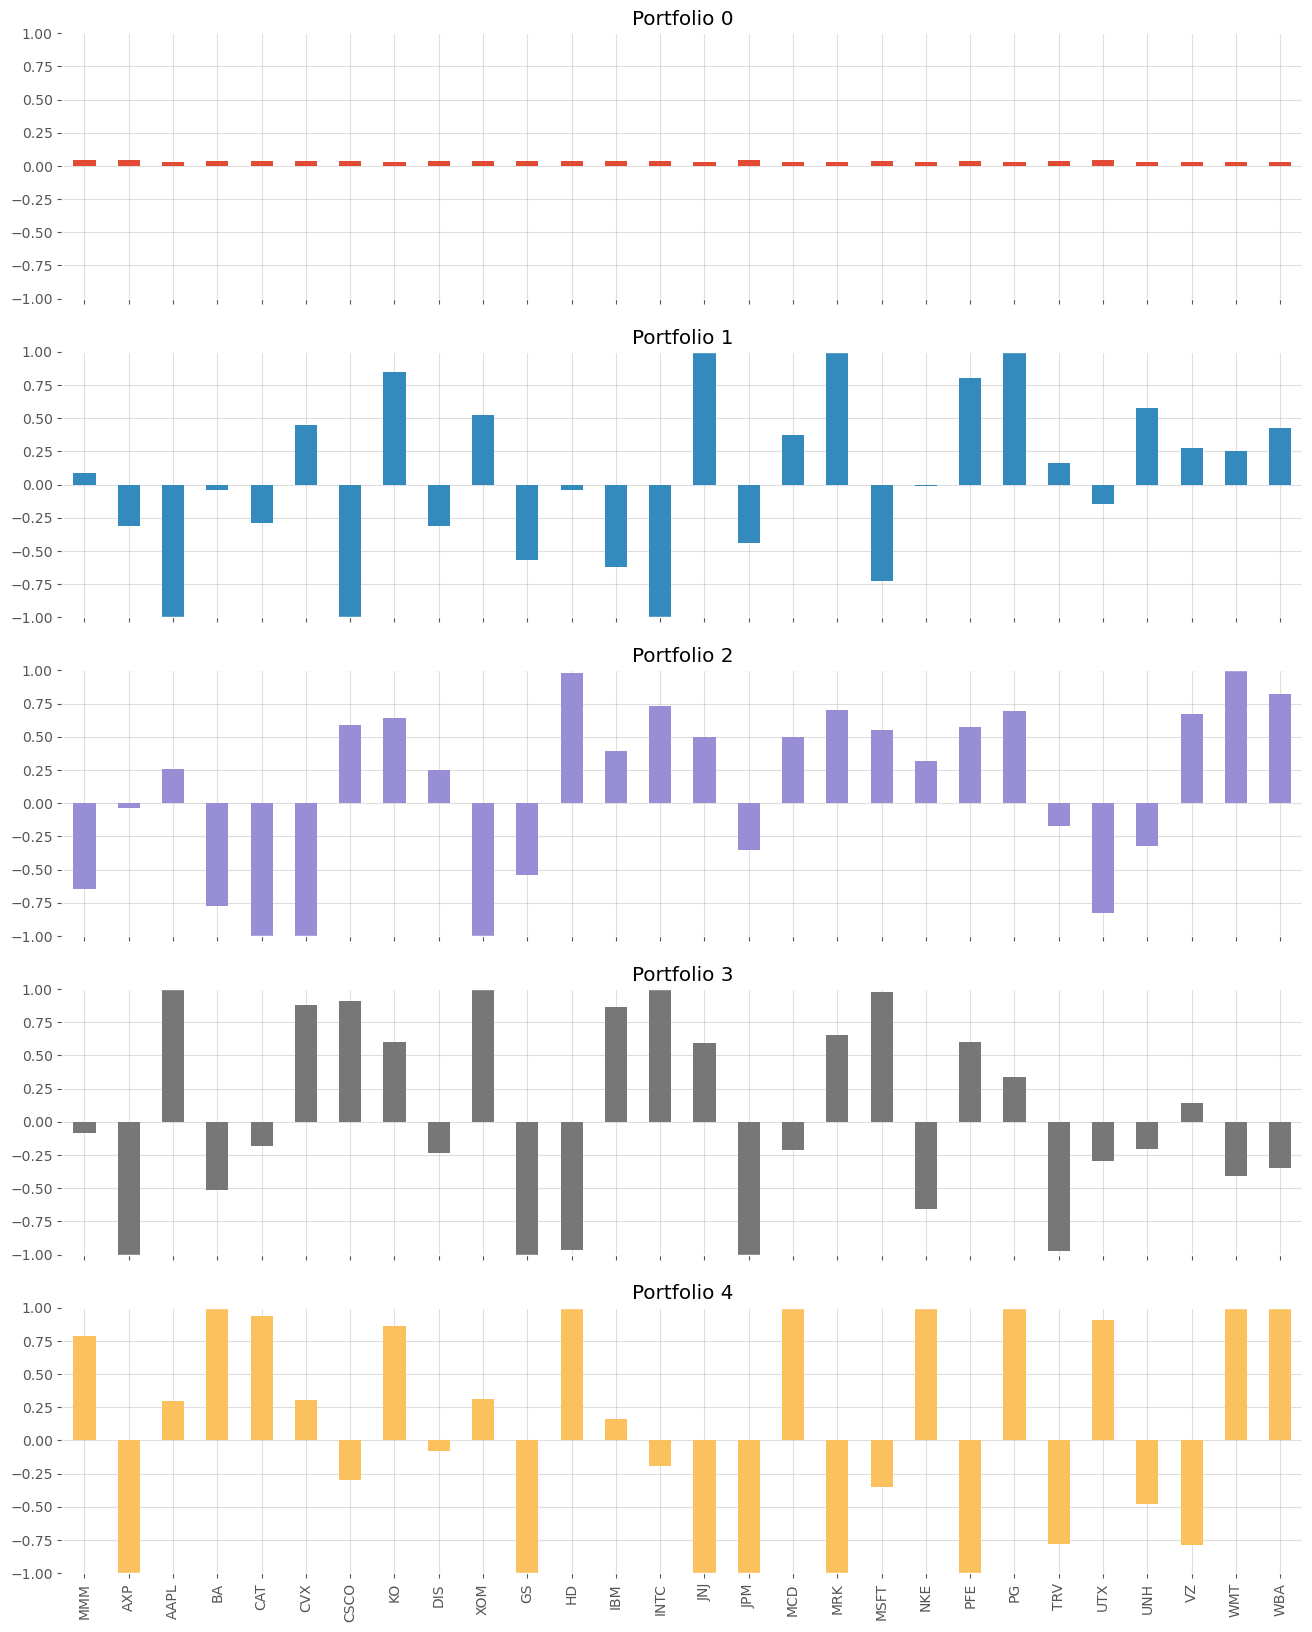

In [16]:
NumComponents = 5

topPortfolios = pd.DataFrame(pca.components_[:NumComponents],
                             columns = dow.columns)

eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis = 0)

eigen_portfolios.index = [f"Portfolio {i}" for i in range( NumComponents)]

np.sqrt(pca.explained_variance_)

eigen_portfolios.T.plot.bar(subplots = True,
                            layout = (int(NumComponents), 1),
                            legend = False,
                            sharey = True,
                            ylim = (-1, 1),
                            figsize = (16, 20)
                           )

<AxesSubplot:>

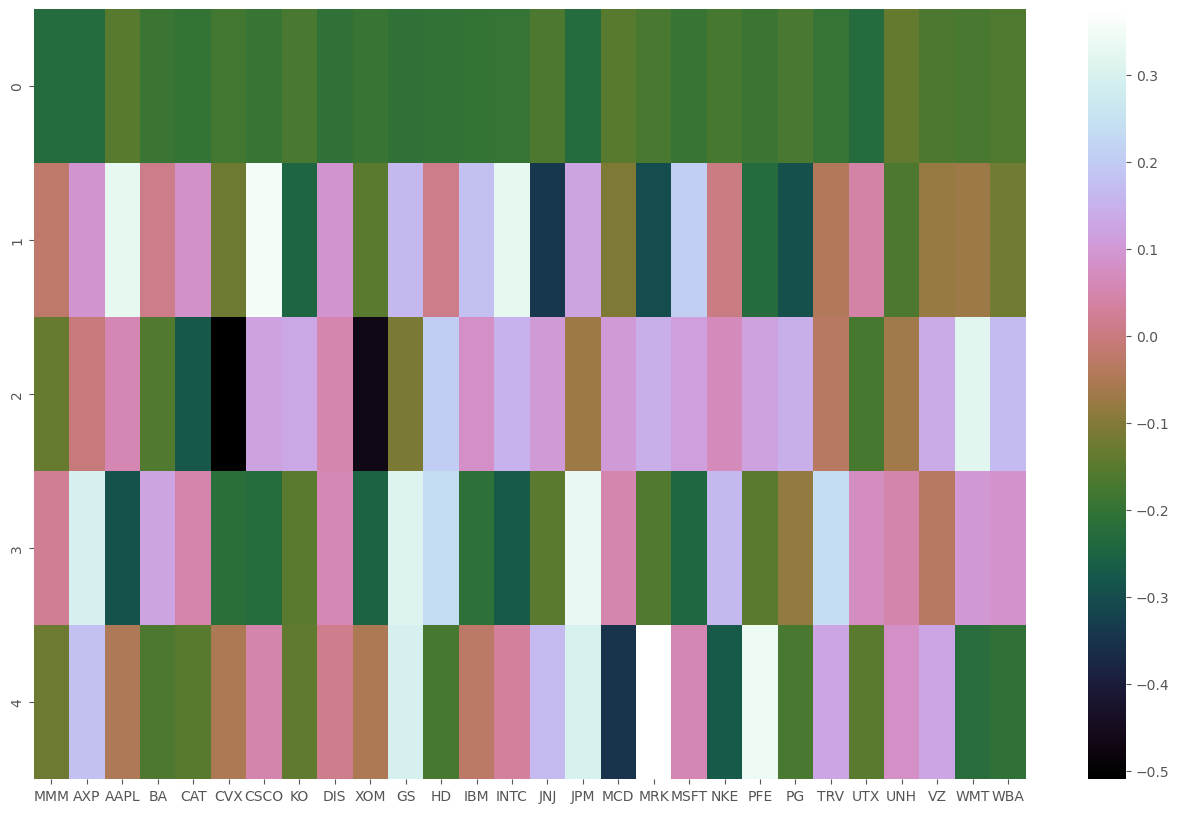

In [17]:
plt.figure(figsize = (16, 10))
sns.heatmap(topPortfolios, cmap = "cubehelix")


In [18]:
def sharpe_ratio(ts_returns, periods_per_year = 252):
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_return, annualized_vol, annualized_sharpe

In [19]:
def FindOptimalPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0
    stock_tickers = scaled_dow.columns.values
    n_tickers = len(stock_tickers)
    PCs = pca.components_
    
    for i in range(n_portfolios):
        pc_w = PCs[i] / sum(PCs[i])
        eigen_prtfi = pd.DataFrame(data = {"weights": pc_w.squeeze()*100}, 
                                   index = stock_tickers)
        eigen_prtfi.sort_values(by = ["weights"],
                                ascending = False,
                                inplace = True)
        eigen_prti_returns = np.dot(X_Train_Raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(),
                                       index = X_Train_Raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
    
    highest_sharpe = np.argmax(sharpe_metric)
    print("Our Eigen Portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f" %
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100,
           annualized_vol[highest_sharpe]*100,
           sharpe_metric[highest_sharpe]
          )
         )
        
    results = pd.DataFrame(data = {"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric})
    results.dropna(inplace = True)
    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)
    
    print(results.head(15))

In [20]:
FindOptimalPortfolio()

Our Eigen Portfolio #0 with the highest Sharpe. Return 11.56%, vol = 13.32%, Sharpe = 0.87
      Return        Vol    Sharpe
0   0.115609   0.133165  0.868168
1   0.055351   0.671441  0.082436
5   0.036402   0.852033  0.042724
18 -1.000000  21.052878 -0.047499
2  -0.105713   0.855441 -0.123578
22 -1.000000   7.697629 -0.129910
7  -0.103673   0.725393 -0.142920
19 -1.000000   6.378805 -0.156769
3  -0.143583   0.744847 -0.192768
13 -0.399829   2.072493 -0.192922
23 -1.000000   5.028982 -0.198847
26 -0.999994   4.550228 -0.219768
10 -0.217405   0.987082 -0.220250
6  -0.450870   2.025684 -0.222577
15 -0.999961   3.857063 -0.259255


> Once we figure out which portfolio has the highest sharpe ratio, we can visualize its performance against the DJIA Index for comparison.

### Make it even better: Add Visual Display of Eigen-Portfolios

In [21]:
def FindPortfolioVisual():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0
    stock_tickers = scaled_dow.columns.values
    n_tickers = len(stock_tickers)
    PCs = pca.components_
    
    for i in range(n_portfolios):
        pc_w = PCs[i] / sum(PCs[i])
        eigen_prtfi = pd.DataFrame(data = {"weights": pc_w.squeeze()*100}, 
                                   index = stock_tickers)
        eigen_prtfi.sort_values(by = ["weights"],
                                ascending = False,
                                inplace = True)
        eigen_prti_returns = np.dot(X_Train_Raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(),
                                       index = X_Train_Raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
            
    highest_sharpe = np.argmax(sharpe_metric)
    
    print("Our Eigen Portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f" %
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100,
           annualized_vol[highest_sharpe]*100,
           sharpe_metric[highest_sharpe]
          )
         )
            
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 6)
    ax.plot(sharpe_metric, linewidth = 2)
    ax.set_title("Sharpe Ratio of Eigen-Portfolios")
    ax.set_ylabel("Sharpe Ratio")
    ax.set_xlabel("Portfolios")
        
    results = pd.DataFrame(data = {"Return": annualized_ret, "Vol": annualized_vol, "Sharpe": sharpe_metric})
    results.dropna(inplace = True)
    results.sort_values(by = ["Sharpe"],
                        ascending = False,
                        inplace = True)
    print(results.head(15))
    plt.show()

Our Eigen Portfolio #0 with the highest Sharpe. Return 11.56%, vol = 13.32%, Sharpe = 0.87
      Return        Vol    Sharpe
0   0.115609   0.133165  0.868168
1   0.055351   0.671441  0.082436
5   0.036402   0.852033  0.042724
18 -1.000000  21.052878 -0.047499
2  -0.105713   0.855441 -0.123578
22 -1.000000   7.697629 -0.129910
7  -0.103673   0.725393 -0.142920
19 -1.000000   6.378805 -0.156769
3  -0.143583   0.744847 -0.192768
13 -0.399829   2.072493 -0.192922
23 -1.000000   5.028982 -0.198847
26 -0.999994   4.550228 -0.219768
10 -0.217405   0.987082 -0.220250
6  -0.450870   2.025684 -0.222577
15 -0.999961   3.857063 -0.259255


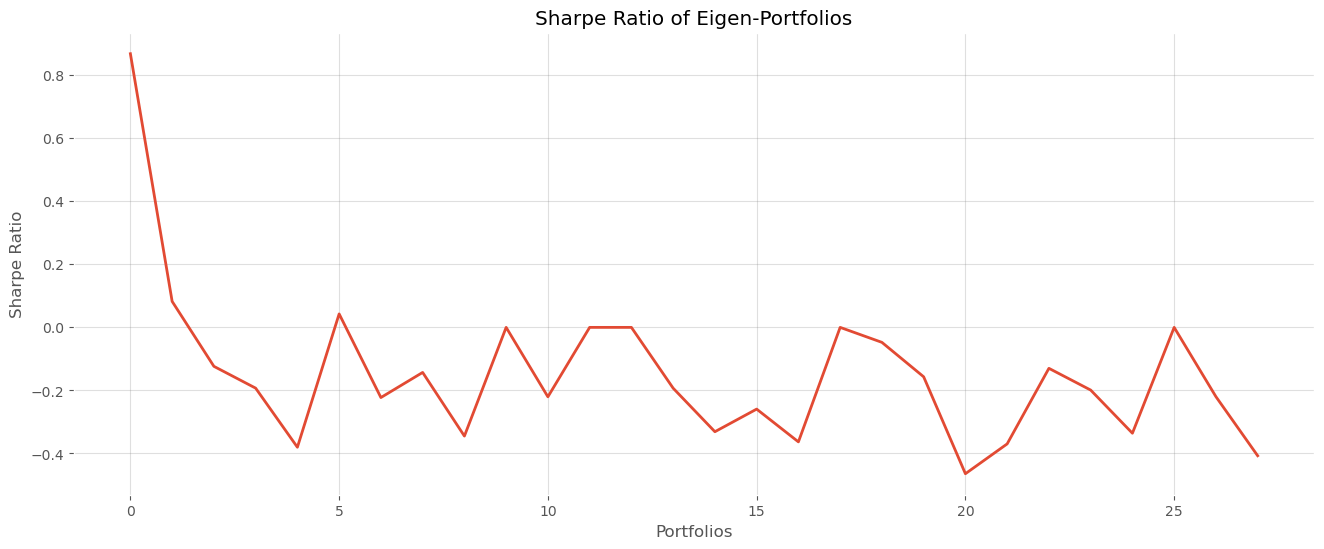

In [22]:
FindPortfolioVisual()

In [23]:
weights = PCWeights()
portfolio = pd.DataFrame()

def VisualizeEigen(weights,
                   plot = False,
                   portfolio = portfolio):
    
    portfolio = pd.DataFrame(data = {"weights": weights.squeeze()*100},
                             index = stock_tickers)
    portfolio.sort_values(by = ["weights"],
                          ascending = False,
                          inplace = True)
    if plot:
        print("Total weights of our Eigen-Portfolio: %2.f" % np.sum(portfolio))
        portfolio.plot(figsize = (14, 10),
                       title = "Eigen-Portfolio Weights",
                       rot = 60,
                       xticks = range(0, len(stock_tickers), 1)
                      )
        plt.show()
    return portfolio

Total weights of our Eigen-Portfolio: 100


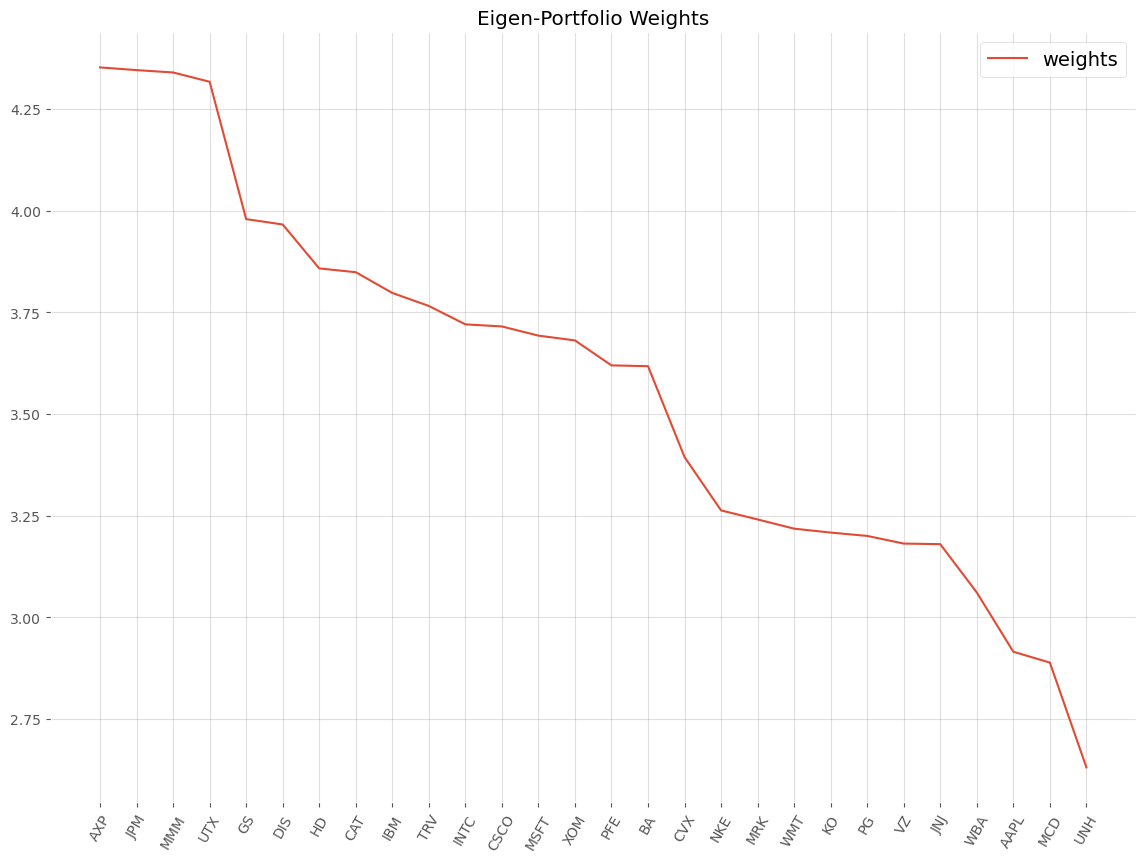

,weights
AXP,4.352333
JPM,4.345624
MMM,4.339861
UTX,4.317033
GS,3.979266
DIS,3.966022
HD,3.858098
CAT,3.848712
IBM,3.797712
TRV,3.765743


In [24]:
VisualizeEigen(weights = weights[0], plot = True)

### Backtesting `Eigen` Portfolio

In [25]:
def Backtest(eigen):
    
    eigen_prtfi = pd.DataFrame(data = {"weights": eigen.squeeze()},
                               index = stock_tickers)
    eigen_prtfi.sort_values(by = ["weights"],
                            ascending = False,
                            inplace = True)
    eigen_prti_returns = np.dot(X_Test_Raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(),
                                        index = X_Test_Raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print("Our PCA-based Portfolio:\nReturn = %.2f%%\nVolatality = %.2f%%\nSharpe = %.2f" % 
          (returns*100, vol*100, sharpe))
    equal_weight_return = (X_Test_Raw * (1 / len(pca.components_))).sum(axis = 1)
    
    df_plot = pd.DataFrame({"Eigen-Portfolio Return": eigen_portfolio_returns,
                            "Equal Weight Index": equal_weight_return},
                           index = X_Test.index)
    
    np.cumprod(df_plot + 1).plot(title = "RETURNS of the equal weighted index versus Eigen-portfolio", figsize = (16, 8))
    plt.show()

Our PCA-based Portfolio:
Return = 22.38%
Volatality = 11.29%
Sharpe = 1.98


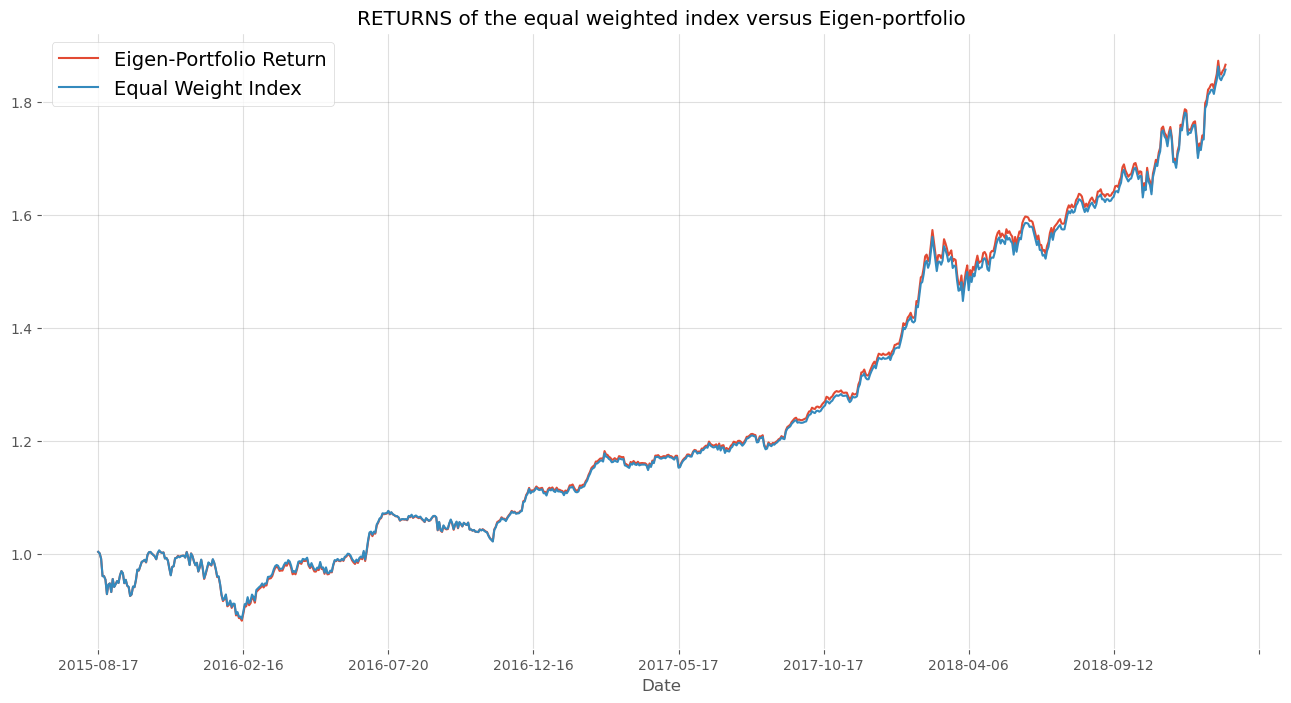

In [26]:
Backtest(eigen = weights[0]) #market following

Our PCA-based Portfolio:
Return = 94.89%
Volatality = 58.28%
Sharpe = 1.63


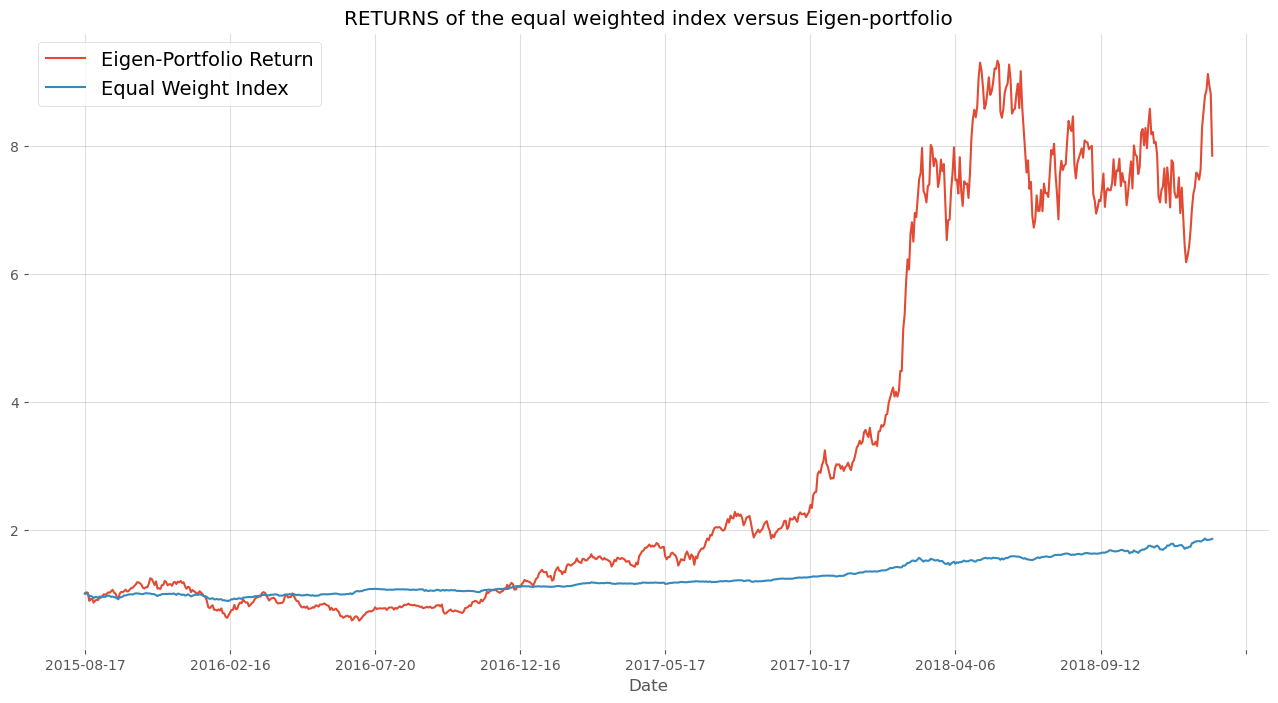

In [27]:
Backtest(eigen = weights[1]) #top eigen portfolio